# TPS SEP 2022

**If you like my work, please, leave an upvote: it will be really appreciated and it will motivate me in offering more content to the Kaggle community ! :)**

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.special import softmax
from cycler import cycler
from IPython.display import display
import datetime

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

In [2]:
from sklearn.linear_model import Ridge

sns.set_style('darkgrid')

In [3]:
data = pd.read_csv("../input/tabular-playground-series-sep-2022/train.csv", parse_dates=["date"])
original_train_df = data.copy()
test_df = pd.read_csv("../input/tabular-playground-series-sep-2022/test.csv", parse_dates=["date"])

In [4]:
print()
print('data')
display(data.head())


data


,row_id,date,country,store,product,num_sold
0,0,2017-01-01,Belgium,KaggleMart,Kaggle Advanced Techniques,663
1,1,2017-01-01,Belgium,KaggleMart,Kaggle Getting Started,615
2,2,2017-01-01,Belgium,KaggleMart,Kaggle Recipe Book,480
3,3,2017-01-01,Belgium,KaggleMart,Kaggle for Kids: One Smart Goose,710
4,4,2017-01-01,Belgium,KaggleRama,Kaggle Advanced Techniques,240


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70128 entries, 0 to 70127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    70128 non-null  int64         
 1   date      70128 non-null  datetime64[ns]
 2   country   70128 non-null  object        
 3   store     70128 non-null  object        
 4   product   70128 non-null  object        
 5   num_sold  70128 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 3.2+ MB


<AxesSubplot:>

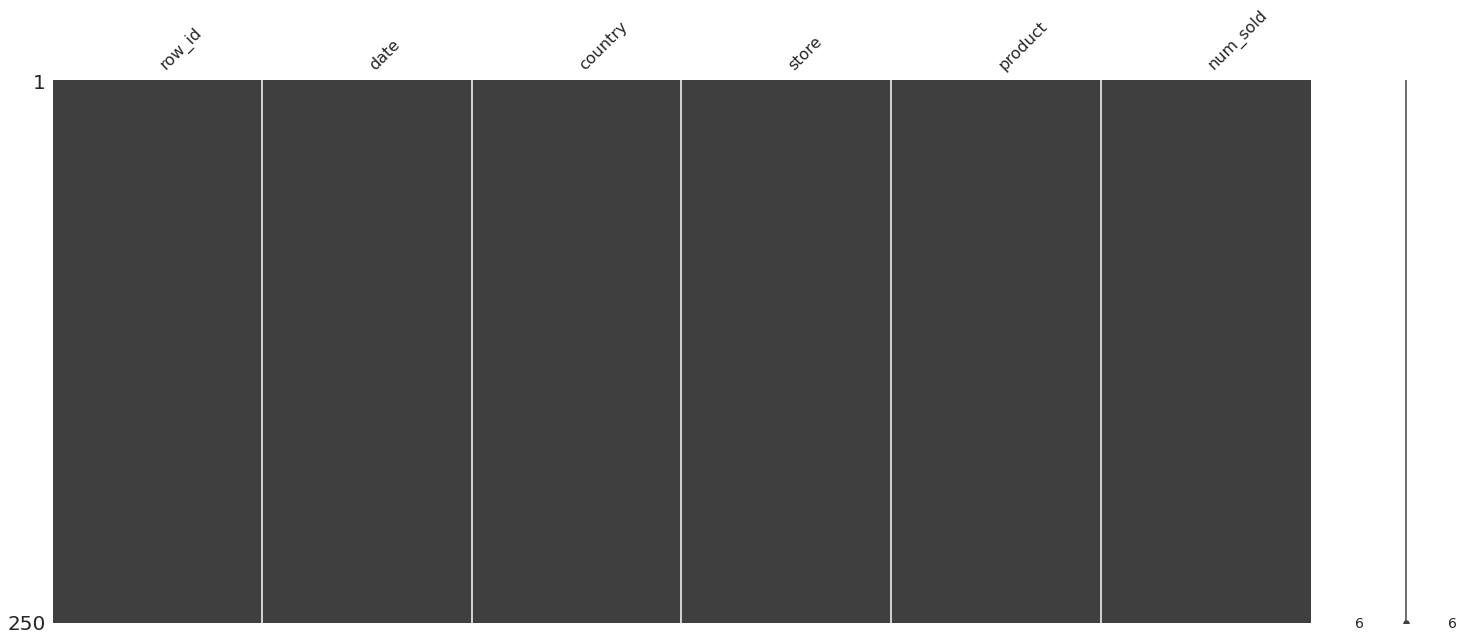

In [6]:
import missingno as msno
%matplotlib inline
msno.matrix(data.sample(250))

In [7]:
display(data.duplicated().sum())

0

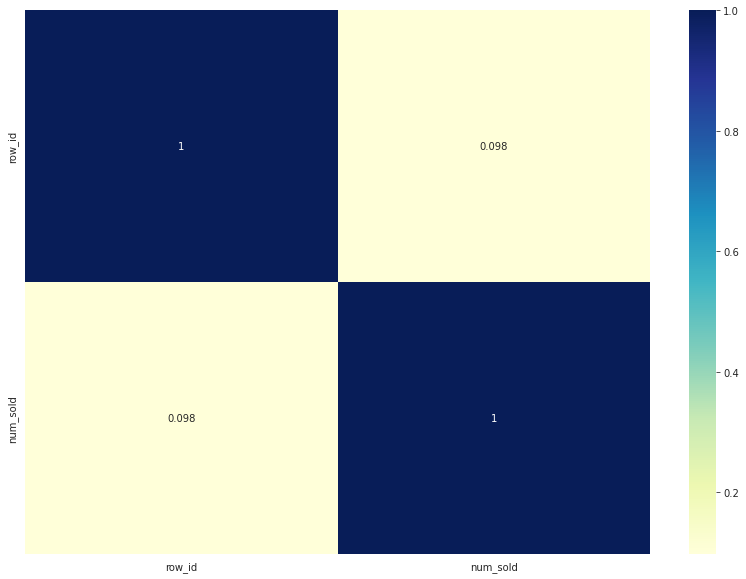

In [8]:
corr=data.corr()
plt.figure(figsize=(14,10))
sns.heatmap(corr, annot=True, cmap='YlGnBu');

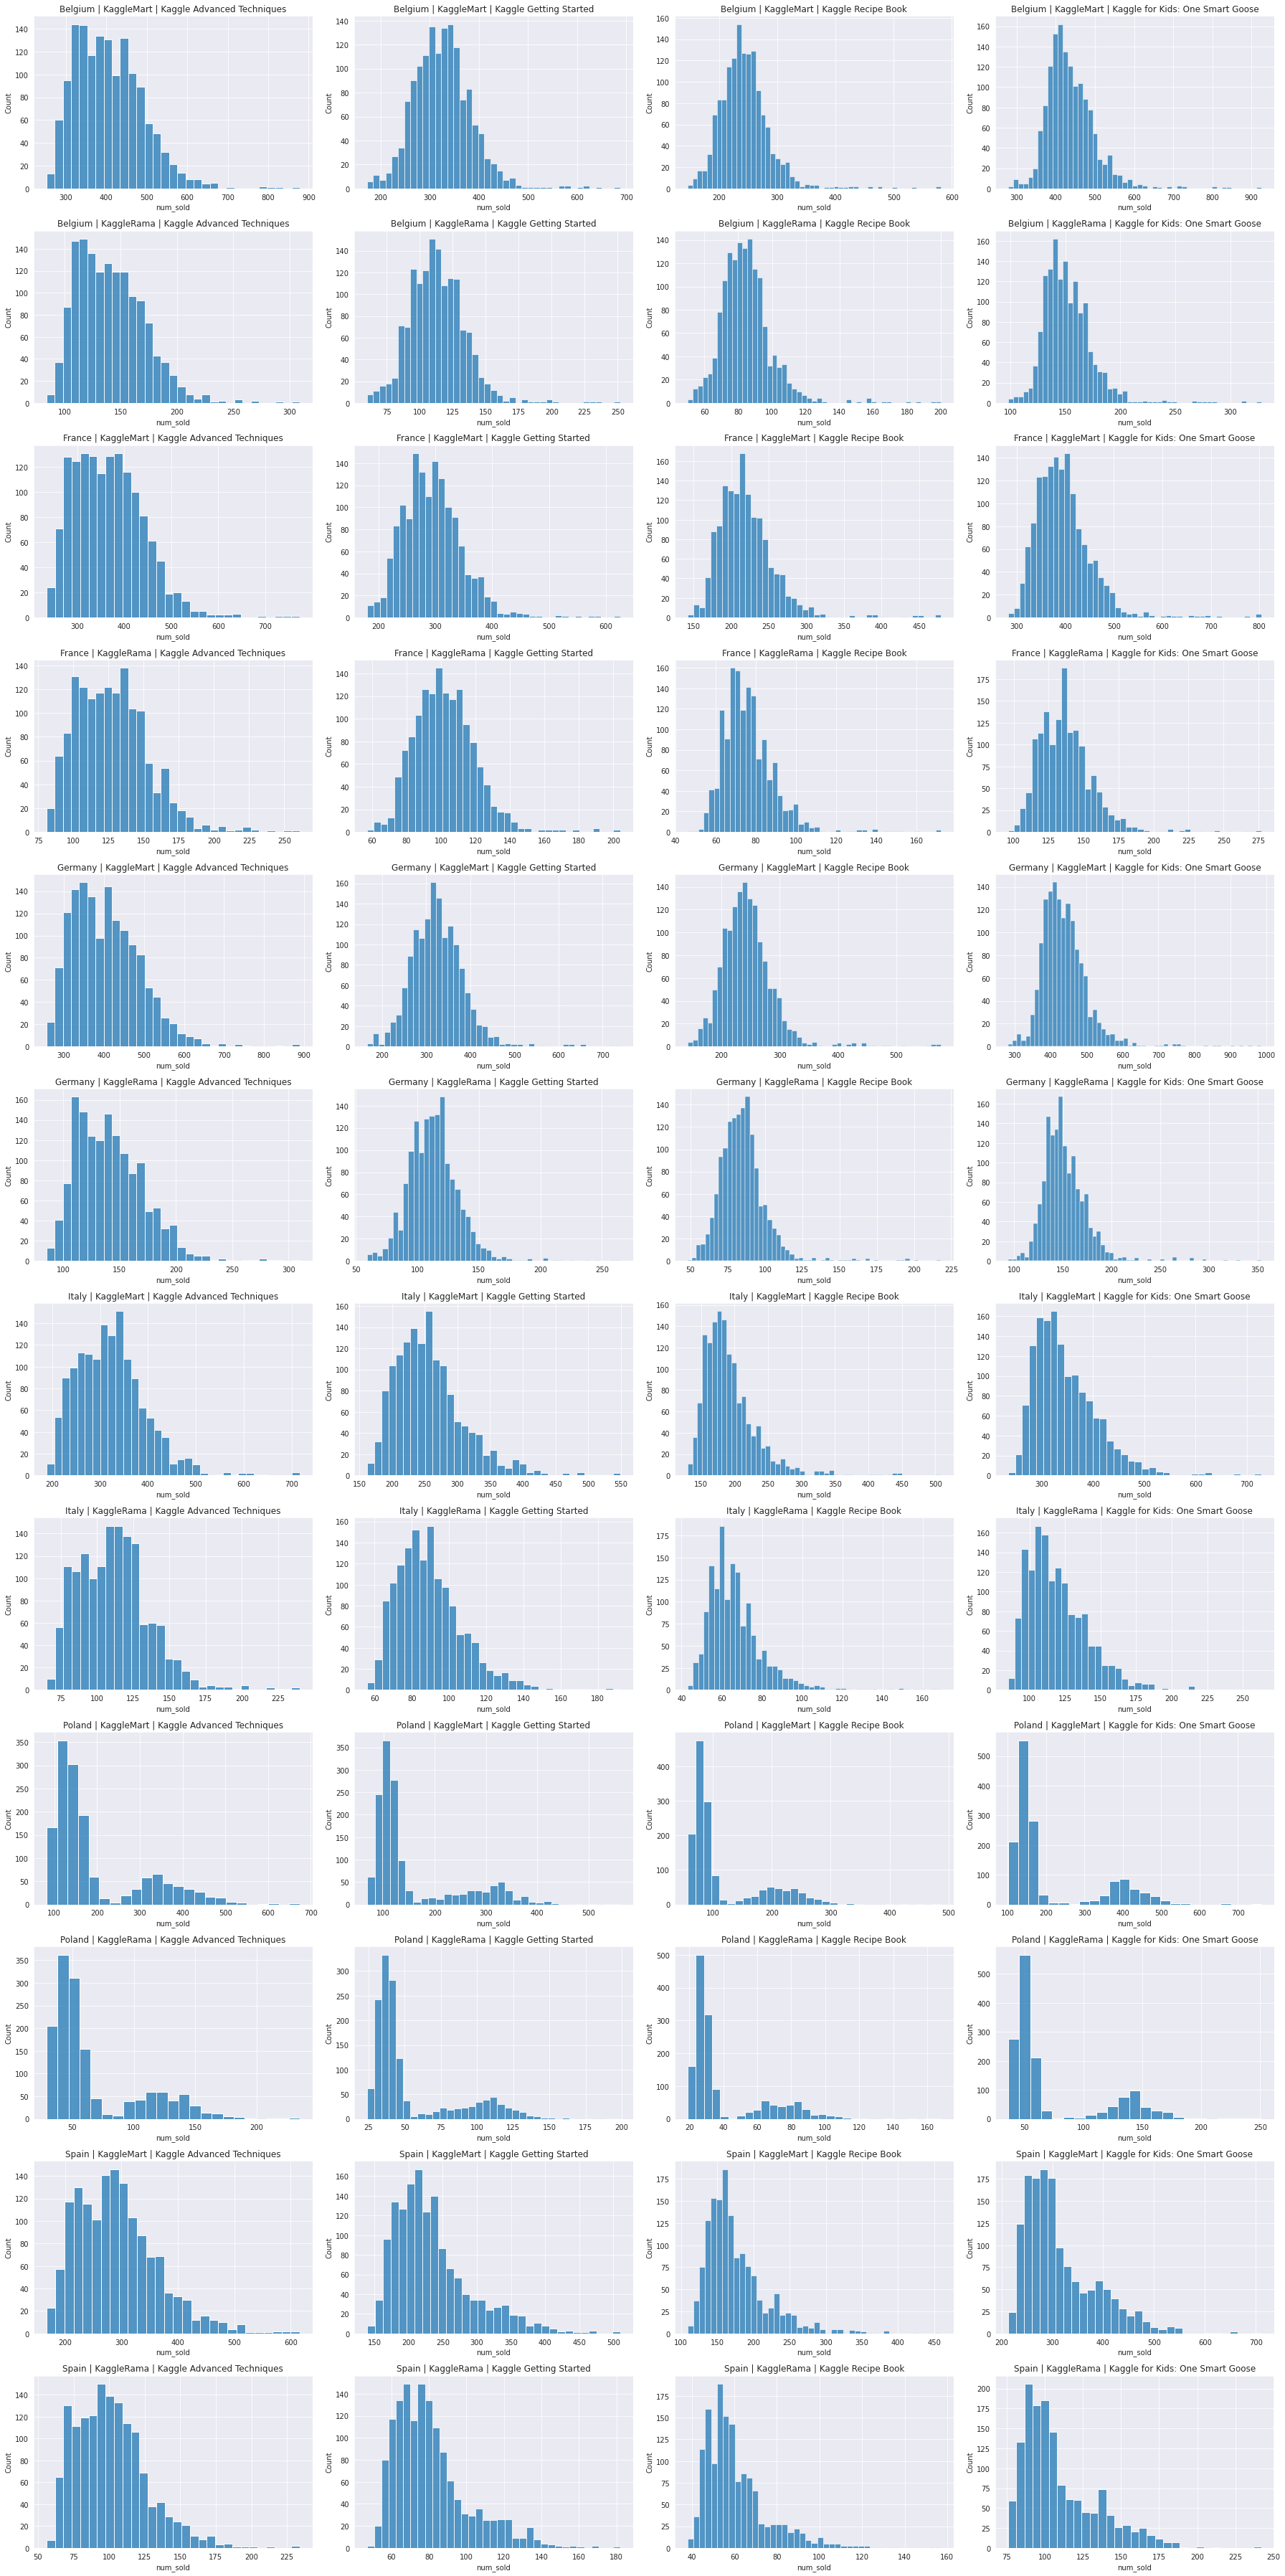

In [9]:
fig, ax = plt.subplots(12, 4, figsize=(25, 50))
ax = ax.flatten()

for i, (combination, data) in enumerate(data.groupby(['country', 'store', 'product'])):
    sns.histplot(data.num_sold, ax=ax[i])
    ax[i].set_title(' | '.join(combination))
plt.tight_layout()

In [10]:
train_df = pd.read_csv(
    "../input/tabular-playground-series-sep-2022/train.csv",
    parse_dates=['date'],
    index_col=0
)

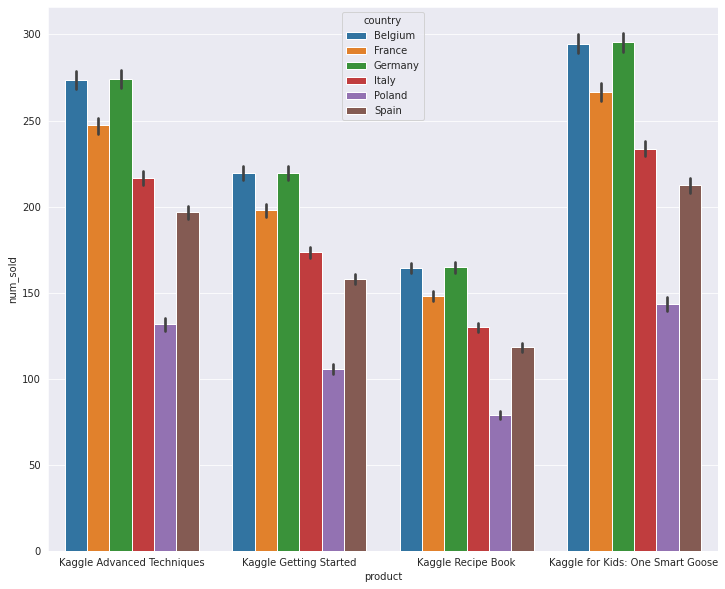

In [11]:
plt.figure(figsize=(12,10))
ax = sns.barplot(data=train_df, x='product', y='num_sold', hue='country');

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
train_df = pd.read_csv("../input/tabular-playground-series-sep-2022/train.csv", parse_dates=["date"])
original_train_df = train_df.copy()
test_df = pd.read_csv("../input/tabular-playground-series-sep-2022/test.csv", parse_dates=["date"])

#grouped for ratio calculation
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()
monthly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()


#ratio sold by store
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
product_store_weights = monthly_df.groupby(["product","store"])["num_sold"].sum() / monthly_df.groupby(["product"])["num_sold"].sum()

#ratio sold by country
new_monthly_df = monthly_df.loc[monthly_df["date"] < "2020-01-01"]
product_country_weights = new_monthly_df.groupby(["product","country"])["num_sold"].sum() / new_monthly_df.groupby(["product"])["num_sold"].sum()

weekly_df = train_df.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()

#product ratios
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()

#num sold summed by date, to be disaggrated
train_df = train_df.groupby(["date"])["num_sold"].sum().reset_index()

#remove covid dates, as they're probably bad signals
train_nocovid_df = train_df.loc[~((train_df["date"] >= "2020-03-01") & (train_df["date"] < "2020-06-01"))]

train_df = train_nocovid_df

#get the dates to forecast for
test_all_df = test_df.groupby(["date"])["row_id"].first().reset_index().drop(columns="row_id")
#keep dates for later
test_all_df_dates = test_all_df[["date"]]

#Important dates, these day of year have extra info, weekends, holiday shopping, etc
important_dates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,16,17, 124, 125, 126, 127, 140, 141,142, 167, 168, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 203, 230, 231, 232, 233, 234, 282, 289, 290, 307, 308, 309, 310, 311, 312, 313, 317, 318, 319, 320, 360, 361, 362, 363, 364, 365]
def feature_engineer(df):
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["month_sin"] = np.sin(new_df['month'] * (2 * np.pi / 12))
    #new_df["month_cos"] = np.cos(new_df['month'] * (2 * np.pi / 12))
    
    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["day_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x<=3 else(1 if x==4 else (2 if x==5 else (3))))
    
    new_df["day_of_year"] = df["date"].dt.dayofyear
    #account for leap year
    new_df["day_of_year"] = new_df.apply(lambda x: x["day_of_year"]-1 if (x["date"] > pd.Timestamp("2020-02-29") and x["date"] < pd.Timestamp("2021-01-01"))  else x["day_of_year"], axis=1)
    new_df["important_dates"] = new_df["day_of_year"].apply(lambda x: x if x in important_dates else 0)
    
    
    new_df["year"] = df["date"].dt.year
    new_df = new_df.drop(columns=["date","month","day_of_year"])
    
    new_df = pd.get_dummies(new_df, columns = ["important_dates","day_of_week"], drop_first=True)
    
    return new_df

train_all_df = feature_engineer(train_df)
test_all_df = feature_engineer(test_all_df)

y = train_all_df["num_sold"]
X = train_all_df.drop(columns="num_sold")
X_test = test_all_df

from sklearn.model_selection import GroupKFold, GridSearchCV

preds_lst = []
kf = GroupKFold(n_splits=4)
scores = []
params = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5],'solver':('auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga') }
for fold, (train_idx, val_idx) in enumerate(kf.split(X, groups=X.year)):
    model = Lasso(tol=0.00001,max_iter=10000,alpha=0.1)#alpha=0.1, solver='sag',
#     clf = GridSearchCV(model, params)
#     clf.fit(X.iloc[train_idx], y.iloc[train_idx])
#     print(clf.best_params_)
    model = make_pipeline(StandardScaler(), model)
    model.fit(X.iloc[train_idx], y.iloc[train_idx])
    preds_lst.append(model.predict(X_test))
    sc =  model.score(X.iloc[val_idx], y.iloc[val_idx])
    scores.append(sc)
    print(fold, X.iloc[val_idx]['year'].unique(), sc)
print("Mean score", np.mean(scores))
preds_df = pd.DataFrame(np.column_stack(preds_lst), columns = ["2017", "2018", "2019", "2020"])
#average predictions from kfold
preds_df['num_sold'] = preds_df.sum(axis = 1)/len(preds_lst)
test_all_df_dates["num_sold"] = preds_df['num_sold']


product_ratio_2019 = product_ratio_df.loc[product_ratio_df["date"].dt.year == 2019].copy()
product_ratio_2019["mm-dd"] = product_ratio_2019["date"].dt.strftime('%m-%d')
product_ratio_2019 = product_ratio_2019.drop(columns="date")

test_product_ratio_df = test_df.copy()
test_product_ratio_df["mm-dd"] = test_product_ratio_df["date"].dt.strftime('%m-%d')

test_product_ratio_df = pd.merge(test_product_ratio_df,product_ratio_2019, how="left", on = ["mm-dd","product"])

test_sub_df = pd.merge(test_df, test_all_df_dates, how="left")
test_sub_df["ratios"] = test_product_ratio_df["ratios"]

def disaggregate_forecast(df):
    new_df = df.copy()
    
    stores_weights = original_train_df.groupby("store")["num_sold"].sum()/original_train_df["num_sold"].sum()
    country_weights = pd.Series(index = test_sub_df["country"].unique(),data = 1/6)

    for country in country_weights.index:
        new_df.loc[(new_df["country"] == country), "num_sold"] = new_df.loc[(new_df["country"] == country), "num_sold"] *  country_weights[country]
        
    for store in store_weights.index:
        new_df.loc[new_df["store"] == store, "num_sold"] = new_df.loc[new_df["store"] == store, "num_sold"] * store_weights[store]
    
    #apply product weights (which is dependent on date)
    new_df["num_sold"] = new_df["num_sold"] * new_df["ratios"]
    new_df["num_sold"] = new_df["num_sold"].round()
    new_df = new_df.drop(columns=["ratios"])
    
    return new_df

0 [2019] -0.5417968226372187
1 [2018] 0.7795725040493207
2 [2017] 0.8605101403106966
3 [2020] -0.5688216447516365
Mean score 0.13236604424279047


In [13]:
final_df = disaggregate_forecast(test_sub_df)

submission = pd.read_csv("../input/tabular-playground-series-sep-2022/sample_submission.csv")
submission["num_sold"] = final_df["num_sold"]

# submission

In [14]:
#regression test 
submission.to_csv('submission.csv', index = False)

# Thank you for reading!

# Please let me know if you have any questions and I look forward to any suggestions 🙂